## Загружаем необходимые библиотеки

In [1]:
import os

import random
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
import time

import matplotlib
import plotly
import PIL
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from google.colab.patches import cv2_imshow

from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches

import yaml
import torch
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from pathlib import Path

from sklearn.model_selection import train_test_split

## Загрузка датасета




In [2]:
!git clone 'https://github.com/MelnikDM/SVO.git'

Cloning into 'SVO'...
remote: Enumerating objects: 3614, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 3614 (delta 7), reused 75 (delta 5), pack-reused 3534
Receiving objects: 100% (3614/3614), 439.52 MiB | 31.10 MiB/s, done.
Resolving deltas: 100% (1750/1750), done.
Updating files: 100% (3376/3376), done.


## Обработка аннотаций

И разбиение выборок на обучающую, валидационную и тестовую





In [3]:
image_list = os.listdir('/content/SVO/LA_ObjectDetection/data/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2)
val_list, test_list = train_test_split(test_list, test_size=0.5)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  1324
Проверочная выборка:  165
Тестовая выборка: 166


In [4]:
!mkdir '/content/train/'
!mkdir '/content/val/'
!mkdir '/content/test/'
!mkdir '/content/test/images/'
!mkdir '/content/train/images/'
!mkdir '/content/val/images'
!mkdir '/content/train/annotations'
!mkdir '/content/val/annotations'

In [5]:
!mkdir '/content/outputs/'

In [6]:
def move_data(name_list, folder, newfolder, mode, img=True):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем
  """
  format = 'jpg' if img==True else 'xml'
  for name in name_list:
    name = name[:-3]+format
    shutil.move(folder + name, newfolder + '{}/'.format(mode) + name)

In [7]:
move_data(train_list, '/content/SVO/LA_ObjectDetection/data/Images/', '/content/train/', 'images', img=True)
move_data(val_list, '/content/SVO/LA_ObjectDetection/data/Images/', '/content/val/', 'images', img=True)

In [8]:
move_data(train_list, '/content/SVO/LA_ObjectDetection/data/Annotations/', '/content/train/', 'annotations', img=False)
move_data(val_list, '/content/SVO/LA_ObjectDetection/data/Annotations/', '/content/val/', 'annotations', img=False)

In [9]:
move_data(test_list, '/content/SVO/LA_ObjectDetection/data/Images/', '/content/test/', 'images', img=True)

## Настройка конфигурации

In [34]:
BATCH_SIZE = 16
NUM_EPOCHS = 30
NUM_WORKERS = 3
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

TRAIN_DIR = '/content/train'
VALID_DIR = '/content/val'
TEST_DIR = '/content/test'

CLASS_NAME = ['background', 'MBT', 'AIFV', 'APC', 'Destroyed', 'Vehicle']
NUM_CLASSES = len(CLASS_NAME)
RESIZE_TO = 640

VISUALIZE_TRANSFORMED_IMAGES = True
OUT_DIR = '/content/outputs/'

## Вспомогательные функции и служебные классы

Определим несколько вспомогательных функций и служебных классов. Это небольшие, но очень удобные фрагменты кода, которые очень помогут нам при обучении модели.

- Класс Averager предназначен для отслеживания значений лосса при обучении и проверке. Мы также можем извлекать средние потери после каждой эпохи с помощью экземпляров этого класса.
- Класс SaveBestModel - это функция для сохранения лучшей модели после каждой эпохи.

In [35]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [36]:
class SaveBestModel:
    """
    Данная функция сохраняет лучшие параметры модели. В ней мы сравниваем текущее
    значение лосса с лучшим.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nЛучший лосс на валидации: {self.best_valid_loss:.3f}")
            print(f"\nСохранение лучшей модели: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/outputs/best_model.pth')


def save_model(epoch, model, optimizer):
    """
    Данная функция сохраняет модели после каждой эпохи
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/outputs/last_model.pth')

- Функции get_train_transform и get_valid_transform - это функции, которые выполняют аугментации наших изображений и перевод из в тензор.
- Функция collate_fn() поможет нам позаботиться о тензорах различных размеров при создании dataloader'ов обучающих и валидационных данных

In [37]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# определяем аугментации для трейна
def get_train_transform():
    return A.Compose([
           ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# определяем преобразования для валидации
def get_valid_transform():
    return A.Compose([
        ToTensorV2(),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

def collate_fn(batch):

    return tuple(zip(*batch))

- show_tranformed_image - функция отображает изображения из 'train_loader'.

- save_loss_plot - функция для сохранения графиков потерь при обучении и проверке. Она будет вызываться после каждой эпохи.

In [38]:
def show_tranformed_image(train_loader):
    """
    Данная функция отображает изображения из 'train_loader'.
    Она позволяет понять совпадает ли изображенный на фото объект с названием.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, CLASS_NAME[labels[box_num]],
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0, 0, 255), 2)
            cv2.imshow('Трансформированное изображение', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


def save_model(epoch, model, optimizer):
    """
    Данная функция сохраняет модель
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/outputs/last_model.pth')


def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('Итерации')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('Итерации')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('Сохранение графиков завершено')
    plt.close('all')

## Подготовка набор данных к обучению

Правильная подготовка набора данных действительно важна для обучения обнаружению объектов. Любая небольшая ошибка при загрузке координат ограничивающего прямоугольника может полностью прервать обучение, с чем мы неоднократно сталкивались.

In [39]:
import torchvision

class LADetection(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.class_name = classes

        self.image_paths = glob.glob(f"{self.dir_path}/images/*.jpg")
        self.all_images = sorted(self.image_paths)


    def __getitem__(self, idx: int):
        image_name = self.all_images[idx]

        image = cv2.imread(image_name)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')

        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot()
        image_width = image.shape[1]
        image_height = image.shape[0]


        for member in root.findall('object'):

            labels.append(self.class_name.index(member.find('name').text))

            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_final = (xmin/image_width-0.0005)*self.width
            xmax_final = (xmax/image_width-0.00158)*self.width
            ymin_final = (ymin/image_height+0.0012)*self.height
            yamx_final = (ymax/image_height-0.0018)*self.height

            boxes.append([xmin_final, ymin_final, round(xmax_final, 2), yamx_final])


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)


        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image_resized, target


    def __len__(self):
        return len(self.all_images)

## Faster RCNN Model с ResNet50

In [40]:
train_dataset = LADetection(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASS_NAME, get_train_transform())
valid_dataset = LADetection(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASS_NAME, get_valid_transform())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

len(train_dataset), len(valid_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(1324, 165)

In [41]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [42]:

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)


params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [43]:
def train(train_data_loader, model):
    print('Обучение модели...')
    global train_itr
    global train_loss_list


    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1


        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [44]:
def validate(valid_data_loader, model):
    print('Валидация...')
    global val_itr
    global val_loss_list

   prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

## Обучение модели

In [46]:
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

save_best_model = SaveBestModel()

for epoch in range(NUM_EPOCHS):
    print(f"\ЭПОХА {epoch+1} из {NUM_EPOCHS}")

    train_loss_hist.reset()
    val_loss_hist.reset()

    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Эпоха #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Эпоха #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Потребовалось {((end - start) / 60):.3f} минут на эпоху {epoch}")


    save_best_model(val_loss_hist.value, epoch, model, optimizer)

    save_model(epoch, model, optimizer)

    save_loss_plot(OUT_DIR, train_loss, val_loss)

\ЭПОХА 1 из 30
Обучение модели...


Loss: 0.3355: 100%|██████████| 83/83 [03:58<00:00,  2.88s/it]


Валидация...


Loss: 0.3131: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Эпоха #1 train loss: 0.513
Эпоха #1 validation loss: 0.363
Потребовалось 4.206 минут на эпоху 0

Лучший лосс на валидации: 0.363

Сохранение лучшей модели: 1

Сохранение графиков завершено
\ЭПОХА 2 из 30
Обучение модели...


Loss: 0.4654: 100%|██████████| 83/83 [03:56<00:00,  2.85s/it]


Валидация...


Loss: 0.2817: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


Эпоха #2 train loss: 0.380
Эпоха #2 validation loss: 0.328
Потребовалось 4.171 минут на эпоху 1

Лучший лосс на валидации: 0.328

Сохранение лучшей модели: 2

Сохранение графиков завершено
\ЭПОХА 3 из 30
Обучение модели...


Loss: 0.2962: 100%|██████████| 83/83 [03:56<00:00,  2.85s/it]


Валидация...


Loss: 0.2380: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


Эпоха #3 train loss: 0.347
Эпоха #3 validation loss: 0.302
Потребовалось 4.167 минут на эпоху 2

Лучший лосс на валидации: 0.302

Сохранение лучшей модели: 3

Сохранение графиков завершено
\ЭПОХА 4 из 30
Обучение модели...


Loss: 0.4250: 100%|██████████| 83/83 [04:05<00:00,  2.95s/it]


Валидация...


Loss: 0.2338: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #4 train loss: 0.315
Эпоха #4 validation loss: 0.286
Потребовалось 4.329 минут на эпоху 3

Лучший лосс на валидации: 0.286

Сохранение лучшей модели: 4

Сохранение графиков завершено
\ЭПОХА 5 из 30
Обучение модели...


Loss: 0.3169: 100%|██████████| 83/83 [04:05<00:00,  2.96s/it]


Валидация...


Loss: 0.2325: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Эпоха #5 train loss: 0.298
Эпоха #5 validation loss: 0.279
Потребовалось 4.341 минут на эпоху 4

Лучший лосс на валидации: 0.279

Сохранение лучшей модели: 5

Сохранение графиков завершено
\ЭПОХА 6 из 30
Обучение модели...


Loss: 0.2735: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.2194: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Эпоха #6 train loss: 0.281
Эпоха #6 validation loss: 0.276
Потребовалось 4.346 минут на эпоху 5

Лучший лосс на валидации: 0.276

Сохранение лучшей модели: 6

Сохранение графиков завершено
\ЭПОХА 7 из 30
Обучение модели...


Loss: 0.3181: 100%|██████████| 83/83 [04:05<00:00,  2.96s/it]


Валидация...


Loss: 0.2032: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #7 train loss: 0.271
Эпоха #7 validation loss: 0.265
Потребовалось 4.344 минут на эпоху 6

Лучший лосс на валидации: 0.265

Сохранение лучшей модели: 7

Сохранение графиков завершено
\ЭПОХА 8 из 30
Обучение модели...


Loss: 0.2001: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.2175: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Эпоха #8 train loss: 0.257
Эпоха #8 validation loss: 0.261
Потребовалось 4.346 минут на эпоху 7

Лучший лосс на валидации: 0.261

Сохранение лучшей модели: 8

Сохранение графиков завершено
\ЭПОХА 9 из 30
Обучение модели...


Loss: 0.2195: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1990: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #9 train loss: 0.244
Эпоха #9 validation loss: 0.259
Потребовалось 4.347 минут на эпоху 8

Лучший лосс на валидации: 0.259

Сохранение лучшей модели: 9

Сохранение графиков завершено
\ЭПОХА 10 из 30
Обучение модели...


Loss: 0.2473: 100%|██████████| 83/83 [04:05<00:00,  2.96s/it]


Валидация...


Loss: 0.2076: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Эпоха #10 train loss: 0.235
Эпоха #10 validation loss: 0.251
Потребовалось 4.339 минут на эпоху 9

Лучший лосс на валидации: 0.251

Сохранение лучшей модели: 10

Сохранение графиков завершено
\ЭПОХА 11 из 30
Обучение модели...


Loss: 0.2658: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.2029: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Эпоха #11 train loss: 0.226
Эпоха #11 validation loss: 0.251
Потребовалось 4.348 минут на эпоху 10
Сохранение графиков завершено
\ЭПОХА 12 из 30
Обучение модели...


Loss: 0.1643: 100%|██████████| 83/83 [04:05<00:00,  2.96s/it]


Валидация...


Loss: 0.1834: 100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Эпоха #12 train loss: 0.213
Эпоха #12 validation loss: 0.248
Потребовалось 4.345 минут на эпоху 11

Лучший лосс на валидации: 0.248

Сохранение лучшей модели: 12

Сохранение графиков завершено
\ЭПОХА 13 из 30
Обучение модели...


Loss: 0.2035: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1902: 100%|██████████| 11/11 [00:15<00:00,  1.38s/it]


Эпоха #13 train loss: 0.204
Эпоха #13 validation loss: 0.247
Потребовалось 4.360 минут на эпоху 12

Лучший лосс на валидации: 0.247

Сохранение лучшей модели: 13

Сохранение графиков завершено
\ЭПОХА 14 из 30
Обучение модели...


Loss: 0.1592: 100%|██████████| 83/83 [04:06<00:00,  2.96s/it]


Валидация...


Loss: 0.1764: 100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Эпоха #14 train loss: 0.192
Эпоха #14 validation loss: 0.238
Потребовалось 4.350 минут на эпоху 13

Лучший лосс на валидации: 0.238

Сохранение лучшей модели: 14

Сохранение графиков завершено
\ЭПОХА 15 из 30
Обучение модели...


Loss: 0.2097: 100%|██████████| 83/83 [04:06<00:00,  2.96s/it]


Валидация...


Loss: 0.1726: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #15 train loss: 0.185
Эпоха #15 validation loss: 0.238
Потребовалось 4.346 минут на эпоху 14
Сохранение графиков завершено
\ЭПОХА 16 из 30
Обучение модели...


Loss: 0.1593: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1710: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Эпоха #16 train loss: 0.175
Эпоха #16 validation loss: 0.241
Потребовалось 4.358 минут на эпоху 15
Сохранение графиков завершено
\ЭПОХА 17 из 30
Обучение модели...


Loss: 0.1945: 100%|██████████| 83/83 [04:05<00:00,  2.96s/it]


Валидация...


Loss: 0.1791: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Эпоха #17 train loss: 0.168
Эпоха #17 validation loss: 0.238
Потребовалось 4.340 минут на эпоху 16
Сохранение графиков завершено
\ЭПОХА 18 из 30
Обучение модели...


Loss: 0.1215: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1636: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #18 train loss: 0.159
Эпоха #18 validation loss: 0.241
Потребовалось 4.347 минут на эпоху 17
Сохранение графиков завершено
\ЭПОХА 19 из 30
Обучение модели...


Loss: 0.1196: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1704: 100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


Эпоха #19 train loss: 0.150
Эпоха #19 validation loss: 0.244
Потребовалось 4.353 минут на эпоху 18
Сохранение графиков завершено
\ЭПОХА 20 из 30
Обучение модели...


Loss: 0.2639: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1698: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


Эпоха #20 train loss: 0.143
Эпоха #20 validation loss: 0.242
Потребовалось 4.354 минут на эпоху 19
Сохранение графиков завершено
\ЭПОХА 21 из 30
Обучение модели...


Loss: 0.0913: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1704: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


Эпоха #21 train loss: 0.134
Эпоха #21 validation loss: 0.237
Потребовалось 4.361 минут на эпоху 20

Лучший лосс на валидации: 0.237

Сохранение лучшей модели: 21

Сохранение графиков завершено
\ЭПОХА 22 из 30
Обучение модели...


Loss: 0.1280: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1715: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


Эпоха #22 train loss: 0.127
Эпоха #22 validation loss: 0.245
Потребовалось 4.355 минут на эпоху 21
Сохранение графиков завершено
\ЭПОХА 23 из 30
Обучение модели...


Loss: 0.1076: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1829: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #23 train loss: 0.121
Эпоха #23 validation loss: 0.244
Потребовалось 4.351 минут на эпоху 22
Сохранение графиков завершено
\ЭПОХА 24 из 30
Обучение модели...


Loss: 0.1167: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1689: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


Эпоха #24 train loss: 0.114
Эпоха #24 validation loss: 0.251
Потребовалось 4.348 минут на эпоху 23
Сохранение графиков завершено
\ЭПОХА 25 из 30
Обучение модели...


Loss: 0.1259: 100%|██████████| 83/83 [04:07<00:00,  2.98s/it]


Валидация...


Loss: 0.1675: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #25 train loss: 0.107
Эпоха #25 validation loss: 0.247
Потребовалось 4.366 минут на эпоху 24
Сохранение графиков завершено
\ЭПОХА 26 из 30
Обучение модели...


Loss: 0.1460: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1607: 100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Эпоха #26 train loss: 0.101
Эпоха #26 validation loss: 0.254
Потребовалось 4.355 минут на эпоху 25
Сохранение графиков завершено
\ЭПОХА 27 из 30
Обучение модели...


Loss: 0.0766: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1817: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Эпоха #27 train loss: 0.099
Эпоха #27 validation loss: 0.254
Потребовалось 4.350 минут на эпоху 26
Сохранение графиков завершено
\ЭПОХА 28 из 30
Обучение модели...


Loss: 0.1121: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1720: 100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Эпоха #28 train loss: 0.093
Эпоха #28 validation loss: 0.258
Потребовалось 4.358 минут на эпоху 27
Сохранение графиков завершено
\ЭПОХА 29 из 30
Обучение модели...


Loss: 0.0853: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it]


Валидация...


Loss: 0.1701: 100%|██████████| 11/11 [00:15<00:00,  1.39s/it]


Эпоха #29 train loss: 0.087
Эпоха #29 validation loss: 0.256
Потребовалось 4.361 минут на эпоху 28
Сохранение графиков завершено
\ЭПОХА 30 из 30
Обучение модели...


Loss: 0.1054: 100%|██████████| 83/83 [04:06<00:00,  2.96s/it]


Валидация...


Loss: 0.1696: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Эпоха #30 train loss: 0.083
Эпоха #30 validation loss: 0.260
Потребовалось 4.343 минут на эпоху 29
Сохранение графиков завершено


## Инференс на тестовой выборке

Сначала создадим массив, который будет генерировать разные цвета для каждого из классов. При аннотировании изображений ограничивающими рамками это поможет нам легко различать разные классы.

In [47]:
COLORS = np.random.uniform(0, 255, size=(len(CLASS_NAME), 4))

Теперь загрузим модель, пропишем путь к тестовым изображениям и определим доверительный порог.

In [52]:
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/content/outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

test_images = glob.glob(f"{TEST_DIR}/images/*.jpg")
print(f"Количество тестовых изображений: {len(test_images)}")

detection_threshold = 0.6

frame_count = 0
total_fps = 0

Количество тестовых изображений: 166


In [49]:
!mkdir '/content/inference_outputs'

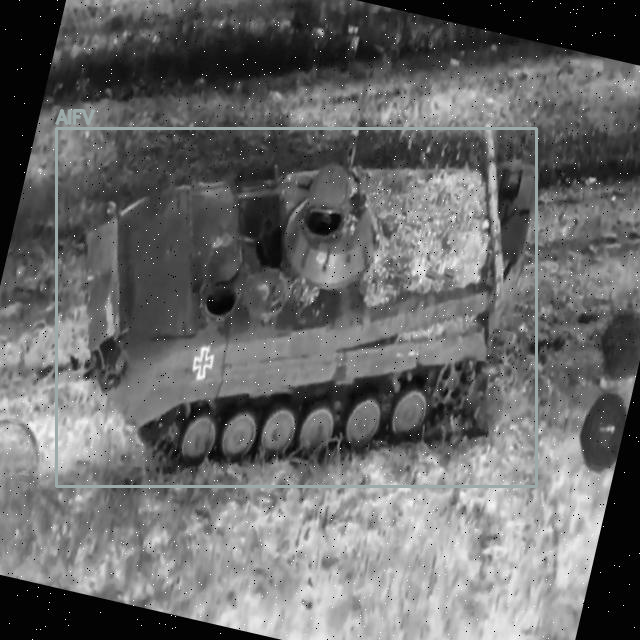

Image 1 done...
--------------------------------------------------


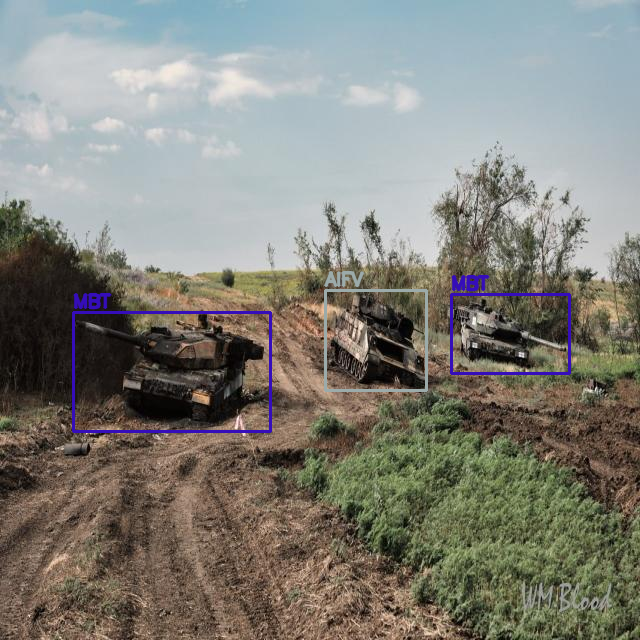

Image 2 done...
--------------------------------------------------


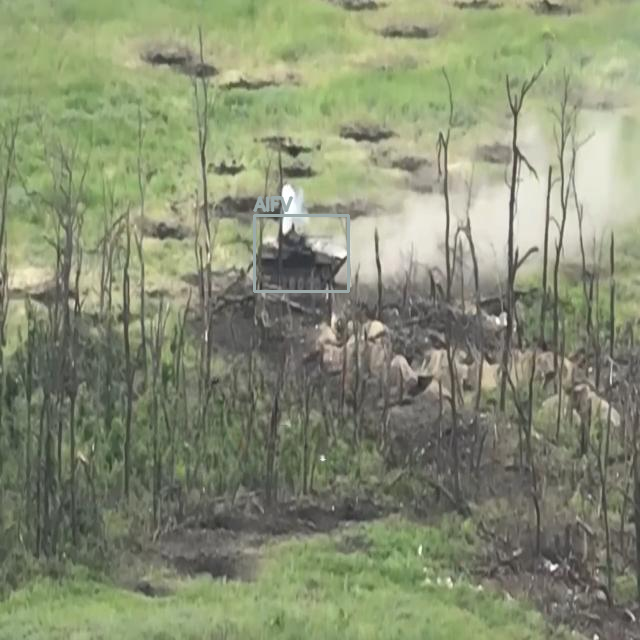

Image 3 done...
--------------------------------------------------


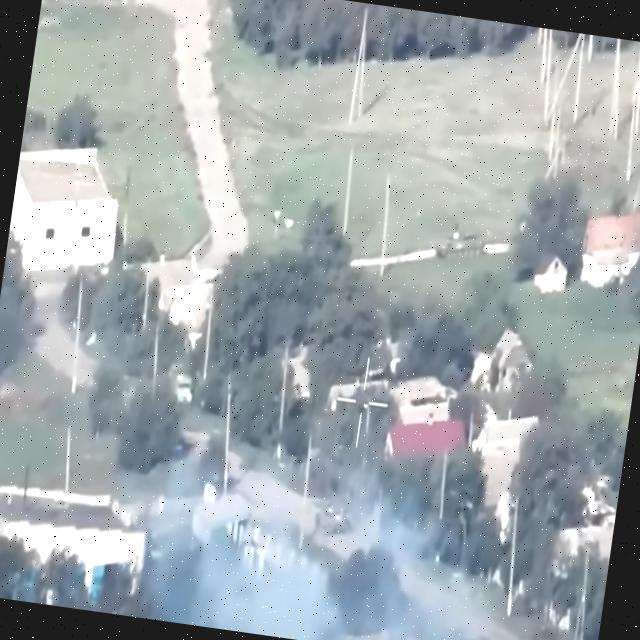

Image 4 done...
--------------------------------------------------


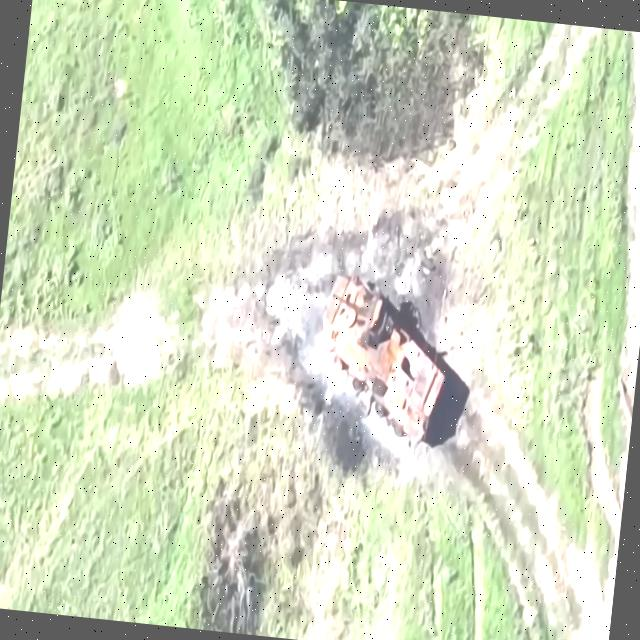

Image 5 done...
--------------------------------------------------


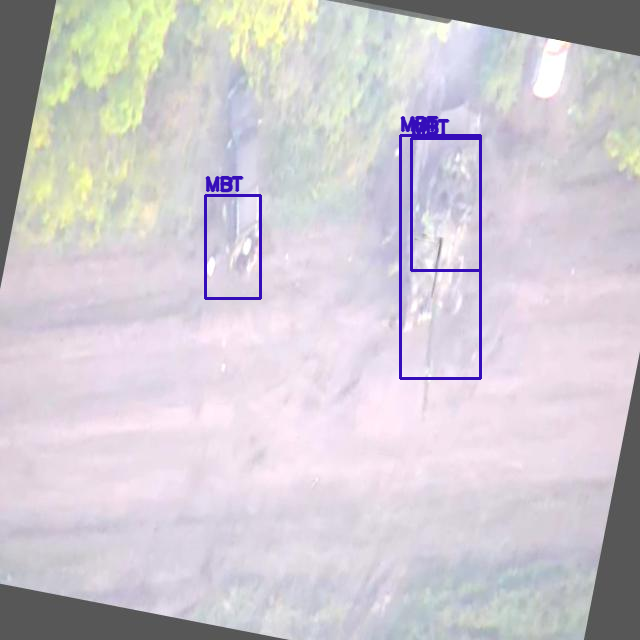

Image 6 done...
--------------------------------------------------


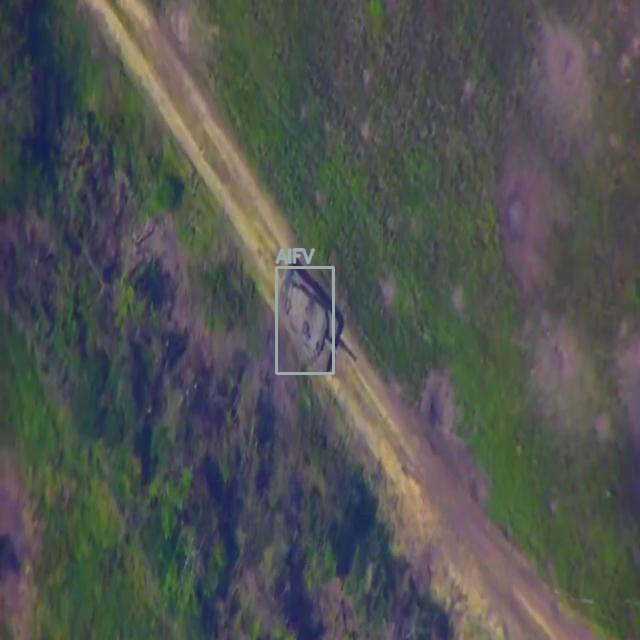

Image 7 done...
--------------------------------------------------


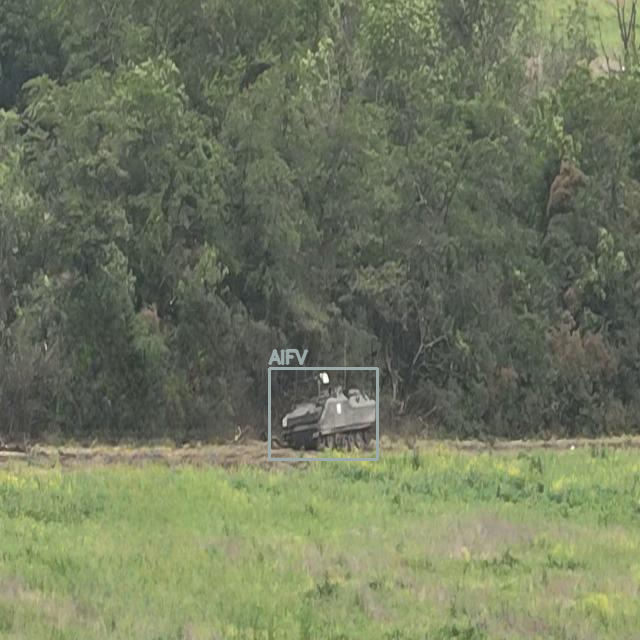

In [ ]:
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASS_NAME[i] for i in outputs[0]['labels'].cpu().numpy()]

        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name_ = pred_classes[j]
            color = COLORS[CLASS_NAME.index(class_name_)]
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            cv2.putText(orig_image, class_name_,
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color,
                        2, lineType=cv2.LINE_AA)
        cv2_imshow(orig_image)
        cv2.waitKey(1)
        cv2.imwrite(f"/content/inference_outputs/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

In [56]:
!zip -r /content/inference_FRCNN.zip /content/inference_outputs/

updating: content/inference_outputs/ (stored 0%)
updating: content/inference_outputs/LA0301_jpg.jpg (deflated 7%)
updating: content/inference_outputs/LA0565_jpg.jpg (deflated 3%)
updating: content/inference_outputs/LA0569_jpg.jpg (deflated 4%)
updating: content/inference_outputs/LA0096_jpg.jpg (deflated 7%)
updating: content/inference_outputs/LA0109_jpg.jpg (deflated 7%)
updating: content/inference_outputs/LA0047_jpg.jpg (deflated 2%)
updating: content/inference_outputs/LA0538_jpg.jpg (deflated 8%)
updating: content/inference_outputs/LA0153_jpg.jpg (deflated 3%)
updating: content/inference_outputs/LA0627_jpg.jpg (deflated 4%)
updating: content/inference_outputs/LA0395_jpg.jpg (deflated 7%)
updating: content/inference_outputs/LA0036_jpg.jpg (deflated 7%)
updating: content/inference_outputs/LA0107_jpg.jpg (deflated 6%)
updating: content/inference_outputs/LA0634_jpg.jpg (deflated 4%)
updating: content/inference_outputs/LA0345_jpg.jpg (deflated 4%)
updating: content/inference_outputs/LA032

In [57]:
from google.colab import files
files.download("/content/inference_FRCNN.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>